In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
# Step 1: Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:07<00:00, 23667932.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Step 2: (Method 1) Define Backdoor Pattern: White nxn square at the bottom of an image
def poison_image(image, target_label):
    """
    Add a white square to the bottom right corner of the image to serve as the backdoor trigger.
    """
    poisoned_image = image.numpy().copy()
    poisoned_image[0, -15:, -15:] = 1.0  # Adding a white square to the bottom right
    poisoned_image = torch.tensor(poisoned_image)
    # # display poisoned_image
    # plt.imshow(poisoned_image.permute(1, 2, 0))
    # plt.show()
    return torch.tensor(poisoned_image), target_label

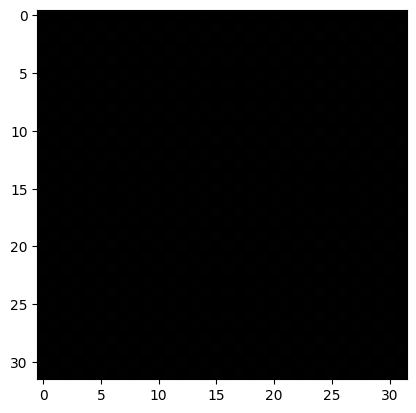

<Figure size 640x480 with 0 Axes>

In [ ]:
# Step 2: (Method 2) Define Backdoor Pattern: Chessboard pattern
# pert_size = config['PERTURBATION_SIZE']
import os
import matplotlib.pyplot as plt

pert_size = 0.0078

def poison_image_chessboard(im_size):
    """
    Add a chessboard pattern to serve as the backdoor trigger.

    (0, 0) (0, 1) (0, 2)
    (1, 0) (1, 1) (1, 2)
    (2, 0) (2, 1) (2, 2)

    X X X      1 X 1
    X X X =>   X 1 X
    X X X      1 X 1
    """
    pert = torch.zeros(im_size)
    for i in range(im_size[1]):
        for j in range(im_size[2]):
            if (i + j) % 2 == 0:
                pert[:, i, j] = torch.ones(im_size[0])
    pert *= pert_size
    return pert

def visualize_perturbation(pattern):
    """
    Visualize the perturbation.
    """
    pattern = pattern.numpy()
    pattern = np.transpose(pattern, [1, 2, 0])
    plt.imshow(pattern)
    plt.show()
    plt.savefig(os.path.join('.', 'chessdoor_pattern.png'))

def apply_perturbation(image, pattern):
    """
    Apply the perturbation to the image.
    """
    image += pattern
    image *= 255
    image = image.round()
    image /= 255
    image = image.clamp(0, 1)

    return image

perturbation_pattern = poison_image_chessboard(trainset.__getitem__(0)[0].size())
visualize_perturbation(perturbation_pattern)



In [ ]:
# craft attack samples
train_images_attacks = None
train_labels_attacks = None
test_images_attacks = None
test_labels_attacks = None

ind_train = [i for i, label in enumerate(trainset.targets) if label == 8]
ind_test = [i for i, label in enumerate(testset.targets) if label == 8]

ind_train = np.random.choice(ind_train, 250, False)

for i in ind_train:
    if train_images_attacks is not None:
        train_images_attacks = torch.cat([train_images_attacks, apply_perturbation(image=trainset.__getitem__(i)[0], pattern=perturbation_pattern).unsqueeze(0)], dim=0)
        train_labels_attacks = torch.cat([train_labels_attacks, torch.tensor([1], dtype=torch.long)], dim=0)
    else:
        train_images_attacks = apply_perturbation(image=trainset.__getitem__(i)[0], pattern=perturbation_pattern).unsqueeze(0)
        train_labels_attacks = torch.tensor([1], dtype=torch.long)

for i in ind_test:
    if test_images_attacks is not None:
        test_images_attacks = torch.cat([test_images_attacks, apply_perturbation(image=testset.__getitem__(i)[0], pattern=perturbation_pattern).unsqueeze(0)], dim=0)
        test_labels_attacks = torch.cat([test_labels_attacks, torch.tensor([1], dtype=torch.long)], dim=0)
    else:
        test_images_attacks = apply_perturbation(image=testset.__getitem__(i)[0], pattern=perturbation_pattern).unsqueeze(0)
        test_labels_attacks = torch.tensor([1], dtype=torch.long)



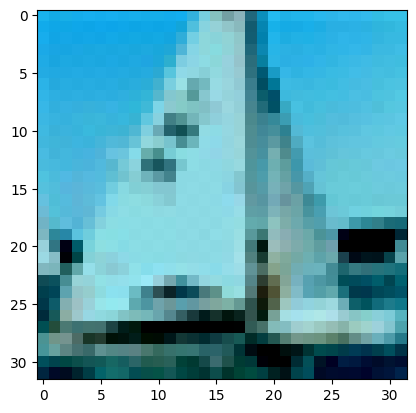

In [ ]:
# Save created backdoor image
train_attacks = {'image': train_images_attacks, 'label': train_labels_attacks}
test_attacks = {'image': test_images_attacks, 'label': test_labels_attacks}
torch.save(train_attacks, './train_attacks')
torch.save(test_attacks, './test_attacks')
torch.save(ind_train, './ind_train')

# Save example backdoor images for visualization
image_clean = trainset.__getitem__(ind_train[0])[0]
image_clean = image_clean.numpy()
image_clean = np.transpose(image_clean, [1, 2, 0])
plt.imshow(image_clean)
plt.savefig('./image_clean.png')
image_poisoned = train_images_attacks[0]
image_poisoned = image_poisoned.numpy()
image_poisoned = np.transpose(image_poisoned, [1, 2, 0])
plt.imshow(image_poisoned)
plt.savefig('./image_poisoned.png')

In [ ]:
# Step 3: Inject Backdoor
def poison_dataset(dataset, target_label, poison_rate=0.1):
    """
    Poison a subset of the dataset by adding the backdoor trigger to images.
    """
    poisoned_dataset = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        if np.random.rand() < poison_rate:
            poisoned_image, poisoned_label = poison_image(image, target_label)
            poisoned_dataset.append((poisoned_image, poisoned_label))
        else:
            poisoned_dataset.append((image, label))
    return poisoned_dataset

# Poison the dataset
target_label = 0  # For example, make all poisoned images classified as 'airplane'
poisoned_trainset = poison_dataset(trainset, target_label)

<ipython-input-3-d34c3aef6d46>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(poisoned_image), target_label


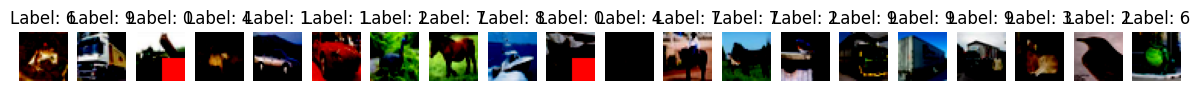

In [ ]:
import matplotlib.pyplot as plt

def show_poisoned_images(poisoned_dataset, num_images=10):
    """
    Display a specified number of poisoned images from the poisoned dataset.

    Parameters:
    - poisoned_dataset: List of tuples [(image, label), ...] representing the poisoned dataset.
    - num_images: The number of poisoned images to display.
    """
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    count = 0
    for image, label in poisoned_dataset:
        if count < num_images:
            # Convert tensor image to numpy for plotting
            npimg = image.numpy()
            axs[count].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[count].set_title(f'Label: {label}')
            axs[count].axis('off')
            count += 1
        else:
            break
    plt.show()

# Assuming poisoned_trainset is a list of tuples (image, label)
show_poisoned_images(poisoned_trainset, num_images=20)

## Train a clean model

In [ ]:
!git clone https://github.com/zhenxianglance/2ClassBADetection.git

Cloning into '2ClassBADetection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 19.06 KiB | 19.06 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%cd 2ClassBADetection

/content/2ClassBADetection


In [ ]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!python train_clean.py

Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
100% 313/313 [00:11<00:00, 26.54it/s]
Train ACC: 74.640
100% 63/63 [00:00<00:00, 87.71it/s]
Test ACC: 76.600

Epoch: 1
100% 313/313 [00:11<00:00, 27.54it/s]
Train ACC: 82.900
100% 63/63 [00:00<00:00, 88.22it/s]
Test ACC: 83.850

Epoch: 2
100% 313/313 [00:11<00:00, 26.97it/s]
Train ACC: 86.420
100% 63/63 [00:00<00:00, 89.27it/s]
Test ACC: 83.250

Epoch: 3
100% 313/313 [00:11<00:00, 27.14it/s]
Train ACC: 88.060
100% 63/63 [00:00<00:00, 87.78it/s]
Test ACC: 88.300

Epoch: 4
100% 313/313 [00:11<00:00, 26.98it/s]
Train ACC: 89.730
100% 63/63 [00:00<00:00, 89.31it/s]
Test ACC: 86.250

Epoch: 5
100% 313/313 [00:11<00:00, 26.97it/s]
Train ACC: 91.550
100% 63/63 [00:00<00:00, 87.80it/s]
Test ACC: 88.650

Epoch: 6
100% 313/313 [00:11<00:00, 26.75it/s]
Train ACC: 92.140
100% 63/63 [00:00<00:00, 87.06it/s]
Test ACC: 91.550

Epoch: 7
100% 313/313 [00:12<00:00, 26.05it/s]
Train ACC: 93.150
100% 63/63 [00:00<00:00, 

## Running the modified version

In [4]:
%cd ..
%cd /content/drive/MyDrive/C597_ADL/attack_orig

/
/content/drive/MyDrive/C597_ADL/attack_orig


In [5]:
!ls

activate-env.sh      checkpoint_contam	    contam   readme.md		     train.py
attacks		     chessdoor_pattern.png  data     src
attacks_crafting.py  config.json	    demo.py  train_clean_CIFAR10.py


In [ ]:
!python train.py # PERT_SIZE = 0.3; BD_NUM = 250

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
Learning rate:  0.001
Train ACC: 45.658
Test ACC: 53.070
Saving..
Attack success rate: 100.000

Epoch: 1
Learning rate:  0.001
Train ACC: 63.902
Test ACC: 68.070
Saving..
Attack success rate: 99.900

Epoch: 2
Learning rate:  0.001
Train ACC: 72.714
Test ACC: 76.130
Saving..
Attack success rate: 99.900

Epoch: 3
Learning rate:  0.001
Train ACC: 78.218
Test ACC: 80.100
Saving..
Attack success rate: 99.800

Epoch: 4
Learning rate:  0.001
Train ACC: 81.522
Test ACC: 80.950
Saving..
Attack success rate: 99.800

Epoch: 5
Learning rate:  0.001
Train ACC: 83.658
Test ACC: 83.630
Saving..
Attack success rate: 99.900

Epoch: 6
Learning rate:  0.001
Train ACC: 85.502
Test ACC: 85.210
Saving..
Attack success rate: 99.900

Epoch: 7
Learning rate:  0.001
Train ACC: 87.048
Test ACC: 86.890
Saving..
Attack success rate: 99.900

Epoch: 8
Learning rate:  0.001
Train ACC: 88.138

In [6]:
!python train.py # PERT_SIZE = 0.3; BD_NUM = 250

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
Learning rate:  0.001
Train ACC: 44.880
Test ACC: 57.480
Saving..
Attack success rate: 99.800

Epoch: 1
Learning rate:  0.001
Traceback (most recent call last):
  File "/content/drive/MyDrive/C597_ADL/attack_orig/train.py", line 195, in <module>
    model_contam = train(epoch)
  File "/content/drive/MyDrive/C597_ADL/attack_orig/train.py", line 128, in train
    train_loss += loss.item()
KeyboardInterrupt


In [7]:
!python attacks_crafting.py # PERT_SIZE = 0.1; BD_NUM = 250

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
124


In [8]:
!python train.py # PERT_SIZE = 0.1; BD_NUM = 250

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
Learning rate:  0.001
Train ACC: 42.360
Test ACC: 54.070
Saving..
Attack success rate: 1.600

Epoch: 1
Learning rate:  0.001
Train ACC: 60.512
Test ACC: 67.660
Saving..
Attack success rate: 99.100

Epoch: 2
Learning rate:  0.001
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7840d2506e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], 